In [1]:
%matplotlib inline

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from matplotlib import gridspec
import matplotlib.patheffects as path_effects
from IPython.display import HTML

import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde
import re
import math
import baltic as bt

In [ ]:
# Set default matplotlib font and font size
typeface = 'Arial'
# Update matplotlib parameters for consistent styling
mpl.rcParams['font.weight'] = 300
mpl.rcParams['axes.labelweight'] = 300
mpl.rcParams['font.family'] = typeface
mpl.rcParams['font.size'] = 22

def kde_scipy(vals1, vals2, range1, range2, N):
    """
    Performs 2D kernel density estimation.

    Args:
        vals1 (array-like): First set of sample values.
        vals2 (array-like): Second set of sample values.
        range1 (tuple): Tuple (a, b) specifying the range for the first dimension.
        range2 (tuple): Tuple (c, d) specifying the range for the second dimension.
        N (int): Number of grid points in each dimension.

    Returns:
        list: A list [x, y, Z], where:
            - x (np.ndarray): Grid values along the first dimension.
            - y (np.ndarray): Grid values along the second dimension.
            - Z (np.ndarray): Estimated density values over the 2D grid.

    Docstring generated with ChatGPT 4o.
    """
    (a, b) = range1
    (c, d) = range2
    x = np.linspace(a, b, N)
    y = np.linspace(c, d, N)
    X, Y = np.meshgrid(x, y)
    positions = np.vstack([Y.ravel(), X.ravel()])
    values = np.vstack([vals1, vals2])
    kernel = gaussian_kde(values)
    Z = np.reshape(kernel(positions).T, X.shape)
    return [x, y, Z]

xml_path = "C:/Users/iblag/Documents/flud/run01/segment4_final.xml"

lpaths = [f"C:/Users/iblag/Documents/flud/run0{run}/segment4_final.state.glm.log"
          for run in range(1, 4)] 
tree_paths = [f"C:/Users/iblag/Documents/flud/run0{run}/segment4_final.trees.txt"
          for run in range(1, 4)] 

In [ ]:
tip_dates = []
for line in open(xml_path, 'r'):
    date_match = re.search(r'<date value="([0-9.]+)"', line)
    if date_match is not None:
        tip_dates.append(date_match.group(1))

mostRecent = max(tip_dates)
print(mostRecent)

predictor_description = {}
read_matrix = False
predictors = []
description = ''
read_loc = False
locations = []
counter = 1
store = ''
print('predictors found:')
design_matrix=0
for line in open(xml_path, 'r'):
    matrixRegex = r'\t+<parameter id="([A-Za-z0-9_.]+)" value="([0-9.\- E]+)"\s*/>'

    if '<designMatrix' in line:
        design_matrix=1
    if design_matrix:
        matrixID = re.search(matrixRegex, line)
        # valid_description = re.search(descriptionRegex, store)
        if matrixID is not None:
            predictor = matrixID.group(1)
            predictors.append(predictor)
            print(predictor)
            counter += 1


    if 'state.dataType' in line:
        read_loc = True

    state_match = re.search(r'<state code="([A-Za-z_]+)"/>', line)
    if read_loc is True and state_match is not None:
        locations.append(state_match.group(1))

    store = line

2024.1693989071039
predictors found:
state.agro_land_perc_destination_logtransform
state.agro_land_perc_origin_logtransform
state.capital_distance_km_offsetlog
state.continent
state.GDP_per_capita_destination_logtransform
state.GDP_per_capita_origin_logtransform
state.land_boarders
state.total_cattle_stock_destination_logtransform
state.total_cattle_stock_origin_logtransform
state.total_swine_stock_destination_logtransform
state.total_swine_stock_origin_logtransform
state.cattle_trade_exp_destination_offsetlog
state.cattle_trade_exp_origin_offsetlog
state.swine_trade_exp_destination_offsetlog
state.swine_trade_exp_origin_offsetlog
state.yearly_precipitation_destination_logtransform
state.yearly_precipitation_origin_logtransform
state.mean_temperatures_destination_logtransform
state.mean_temperatures_origin_logtransform


In [ ]:
def compute_hpd(samples, alpha=0.05):
    """
    Compute the 100*(1-alpha)% HPD interval for a set of samples.

    Args:
        samples (array-like): A 1D array or list of samples from a posterior distribution.
        alpha (float, optional): Significance level (1 - credible interval). 
                                 Defaults to 0.05 for a 95% HPD interval.

    Returns:
        tuple: A tuple (hpd_min, hpd_max) representing the lower and upper bounds 
               of the HPD interval.

    Docstring generated with ChatGPT 4o.
    """
    samples = np.sort(samples)
    n = len(samples)
    interval_idx_inc = int(np.floor((1 - alpha) * n))
    n_intervals = n - interval_idx_inc
    interval_width = samples[interval_idx_inc:] - samples[:n_intervals]
    
    min_idx = np.argmin(interval_width)
    hpd_min = samples[min_idx]
    hpd_max = samples[min_idx + interval_idx_inc]
    
    return hpd_min, hpd_max



matrix_index = {}
origin_indices = {x: [] for x in locations}
destination_indices = {x: [] for x in locations}

lg = len(locations)
for i in range(lg):
    for j in range(i + 1, lg):
        locA = locations[i]
        countryA = locA

        locB = locations[j]
        countryB = locB

        f1 = int((lg * (lg - 1) / 2) - (lg - i) * ((lg - i) - 1) / 2 + j - i - 1)
        f2 = int((lg * (lg - 1)) - (lg - i) * ((lg - i) - 1) / 2 + j - i - 1)

        matrix_index[f1] = (locations[i], locations[j])
        matrix_index[f2] = (locations[j], locations[i])

        origin_indices[locA].append(f1)
        origin_indices[locB].append(f2)

        destination_indices[locB].append(f1)
        destination_indices[locA].append(f2)


burnin = 10000000
trait='state'
required_coeffs = ['%s.coefficients%d' % (trait, x + 1) for x in range(len(predictors))]
required_indicators = ['%s.coefIndicators%d' % (trait, x + 1) for x in range(len(predictors))]

GLM_coeffs = {x: [] for x in predictors}
GLM_indicators = {x: [] for x in predictors}

for log_path in lpaths:
    for line in open(log_path, 'r'):
        l = line.strip('\n').split('\t')
        if l[0] == 'state':
            header = l
            indices_coeffs = [i for i, x in enumerate(header) if x in required_coeffs]
            indices_indicators = [i for i, x in enumerate(header) if x in required_indicators]
        elif '#' in line:
            pass

        elif int(l[0]) >= burnin:
            for i, j, x in zip(indices_coeffs, indices_indicators, predictors):
                GLM_indicators[x].append(float(l[j]))
                GLM_coeffs[x].append(float(l[i]))

priorProbability = 1 - math.pow(0.5, (1 / float(len(predictors))))
priorOdds = float(priorProbability / float(1 - priorProbability))

BFs = {}

print('\npredictor analysis:')
print('%3s%42s%10s%25s%10s%7s' % ('idx', 'predictor', 'beta', '95% HPD', 'indicMean', 'BF'))

GLM_conditional_coeffs = {}

for i, x in enumerate(predictors):
    L = len(GLM_indicators[x])
    if L == 0:
        GLM_coeffs.pop(x, None)
        GLM_indicators.pop(x, None)
    else:
        clean_name = x.replace('state.', '')
        MCMClen = L
        support = np.mean(GLM_indicators[x])
        conditioned_coeff = [a for a, b in zip(GLM_coeffs[x], GLM_indicators[x]) if b == 1.0]
        GLM_conditional_coeffs[x] = conditioned_coeff
        posteriorOdds = (((support - (1 / float(MCMClen))) / float((1 - (support - (1 / float(MCMClen)))))))
        BFs[x] = posteriorOdds / float(priorOdds)
        note = ' '
        if BFs[x] > 3.0:
            note = '*'
        hpd_min, hpd_max = compute_hpd(np.array(conditioned_coeff)) if conditioned_coeff else (float('nan'), float('nan'))
        print('%3s%s%42s%10.2f%25s%10.2f%7.2f' % (
            i + 1,
            note,
            clean_name,
            np.mean(conditioned_coeff),
            f"[{hpd_min:.4f}, {hpd_max:.4f}]",
            support,
            BFs[x]
        ))



predictor analysis:
idx                                 predictor      beta                  95% HPD indicMean     BF
  1    agro_land_perc_destination_logtransform      0.26        [-0.1280, 0.5117]      0.00   0.02
  2         agro_land_perc_origin_logtransform      0.31        [-0.3940, 0.9808]      0.00   0.03
  3              capital_distance_km_offsetlog     -0.93        [-2.2380, 0.3064]      0.00   0.08
  4                                  continent      1.63         [0.6740, 2.5020]      0.06   1.63
  5    GDP_per_capita_destination_logtransform     -0.10        [-0.5882, 0.3677]      0.00   0.02
  6         GDP_per_capita_origin_logtransform      0.52         [0.0254, 1.4802]      0.00   0.05
  7*                             land_boarders      2.22         [1.3970, 3.0403]      0.34  14.17
  8 total_cattle_stock_destination_logtransform     -0.06        [-0.3523, 0.4345]      0.00   0.01
  9     total_cattle_stock_origin_logtransform      0.02        [-0.6635, 0.8183]      0

In [ ]:
# Initialize the migration matrix
migration_matrix = {country: {dest_country: [] for dest_country in locations} for country in locations}


trait= 'state'
for tree_file in tree_paths:
    burned = 0
    for line in open(tree_file, 'r'):
        tree_match = re.search(r'^tree STATE_(\d+).*', line)
        if tree_match is not None:
            state_number = int(tree_match.group(1))
            if state_number >= burnin:
                burned=1
            if burned:
                treestring_match = re.search(r'= \[.*?\] (.*);', line)
                if treestring_match:
                    treestring = treestring_match.group(1)
                    treestring= treestring+";"
                    ll = bt.make_tree(treestring)
                    tree_migration_count = {country: {dest_country: 0 for dest_country in locations} 
                                            for country in locations}
                    for k in ll.Objects:
                        cur_state = k.traits[trait]
                        if not k.parent.traits:
                            continue
                        par_state = k.parent.traits[trait]

                        if par_state != cur_state:
                            migration = '%s>%s' % (par_state, cur_state)
                            tree_migration_count[par_state][cur_state] += 1
    #update matrix with info from one tree
                        for country in tree_migration_count:
                            for dest_country in tree_migration_count[country]:
                                if country == dest_country:
                                    migration_matrix[country][dest_country] = None
                                else:
                                    migration_matrix[country][dest_country].append(tree_migration_count[country][dest_country])



In [6]:
import arviz as az

mean_migration = {country: {dest_country: None for dest_country in locations} for country in locations}
HPD_migration = {country: {dest_country: None for dest_country in locations} for country in locations}
median_migration = {country: {dest_country: None for dest_country in locations} for country in locations}

# Loop through migration_matrix
for key, value in migration_matrix.items():
    for key2, value2 in value.items():
        if value2 is not None and isinstance(value2, list) and len(value2) > 0:  # Check if value2 is a non-empty list
            mean = np.mean(value2)  # Calculate the mean of the list
            median = np.median(value2)  # Calculate the median of the list
            # Convert the list to a numpy array
            data_array = np.array(value2)
            # Calculate the 95% HPD interval
            hpd_interval = az.hdi(data_array, credible_interval=0.95)
            mean_migration[key][key2] = mean
            median_migration[key][key2] = median
            HPD_migration[key][key2] = hpd_interval  # Fixed typo: changed hdp_interval to hpd_interval


In [ ]:
# Function to filter the nested dictionary
def filter_hpd(migration_data):
    """
    Filters migration data to exclude entries with None or zero-valued HPD intervals.

    This function removes destination countries with:
        - `None` values
        - NumPy arrays equal to [0, 0], which typically represent undefined or empty HPD intervals.

    Args:
        migration_data (dict): A nested dictionary where keys are origin countries and
                               values are dictionaries mapping destination countries to 
                               HPD interval values (e.g., numpy arrays or None).

    Returns:
        dict: A filtered version of the input dictionary containing only valid HPD intervals.

    Docstring generated with ChatGPT 4o.
    """
    filtered_data = {}
    
    for country, destinations in migration_data.items():
        filtered_destinations = {}
        for dest_country, value in destinations.items():
            if value is not None and not (isinstance(value, np.ndarray) and np.array_equal(value, np.array([0, 0]))):
                filtered_destinations[dest_country] = value
        if filtered_destinations:
            filtered_data[country] = filtered_destinations
    
    return filtered_data

# Get the filtered migration data
filtered_migration_data = filter_hpd(HPD_migration)

# Print the filtered results
print(filtered_migration_data)

{'Australia': {'Japan': array([0, 1])}, 'Canada': {'Italy': array([0, 1]), 'USA': array([0, 1])}, 'China': {'Japan': array([0, 1]), 'Turkey': array([0, 1])}, 'France': {'Italy': array([0, 1]), 'Turkey': array([0, 1])}, 'Italy': {'China': array([0, 1]), 'Denmark': array([0, 2]), 'France': array([0, 6]), 'Netherlands': array([0, 1]), 'Sweden': array([0, 2]), 'Turkey': array([0, 1]), 'United_Kingdom': array([0, 1])}, 'Japan': {'Australia': array([0, 2]), 'China': array([0, 1]), 'Turkey': array([0, 1]), 'USA': array([0, 1])}, 'Turkey': {'China': array([0, 1])}, 'USA': {'Australia': array([0, 1]), 'Canada': array([0, 3]), 'China': array([0, 1]), 'Denmark': array([0, 1]), 'France': array([0, 1]), 'Italy': array([0, 3]), 'Japan': array([0, 1]), 'Mexico': array([0, 2]), 'Namibia': array([0, 1])}}


In [8]:
ordered_locations=['Namibia', 'Australia', 'Japan', 'China', 'Turkey', 'Italy', 'Sweden', 'Denmark', 'France', 'Netherlands', 'United_Kingdom', 'Mexico', 'Canada', 'USA']
empty = np.full((len(ordered_locations), len(ordered_locations)), np.nan)

# Create a DataFrame to hold analysis results
analysis = pd.DataFrame(empty, index=ordered_locations, columns=ordered_locations)

# Populate the matrix with the posterior number of jumps
for i in ordered_locations:
    for j in ordered_locations:
        if i != j:
            analysis.loc[i, j] = mean_migration[i][j]

print(analysis)

                 Namibia  Australia     Japan     China    Turkey     Italy  \
Namibia              NaN   0.000688  0.001045  0.016876  0.000199  0.000034   
Australia       0.000371        NaN  0.089121  0.034915  0.025953  0.000070   
Japan           0.000625   0.756833       NaN  0.309769  0.236175  0.000178   
China           0.052545   0.059904  0.070282       NaN  0.205561  0.000488   
Turkey          0.000145   0.029479  0.037178  0.102855       NaN  0.001445   
Italy           0.000335   0.000743  0.001038  0.484937  0.371873       NaN   
Sweden          0.000137   0.000958  0.001358  0.000308  0.000205  0.000526   
Denmark         0.000258   0.000919  0.001516  0.000685  0.001601  0.003646   
France          0.000358   0.000841  0.001162  0.001043  0.109055  0.077455   
Netherlands     0.000273   0.001099  0.001658  0.000622  0.000329  0.000261   
United_Kingdom  0.000335   0.000952  0.001843  0.000779  0.000356  0.000756   
Mexico          0.003573   0.010034  0.014269  0.006

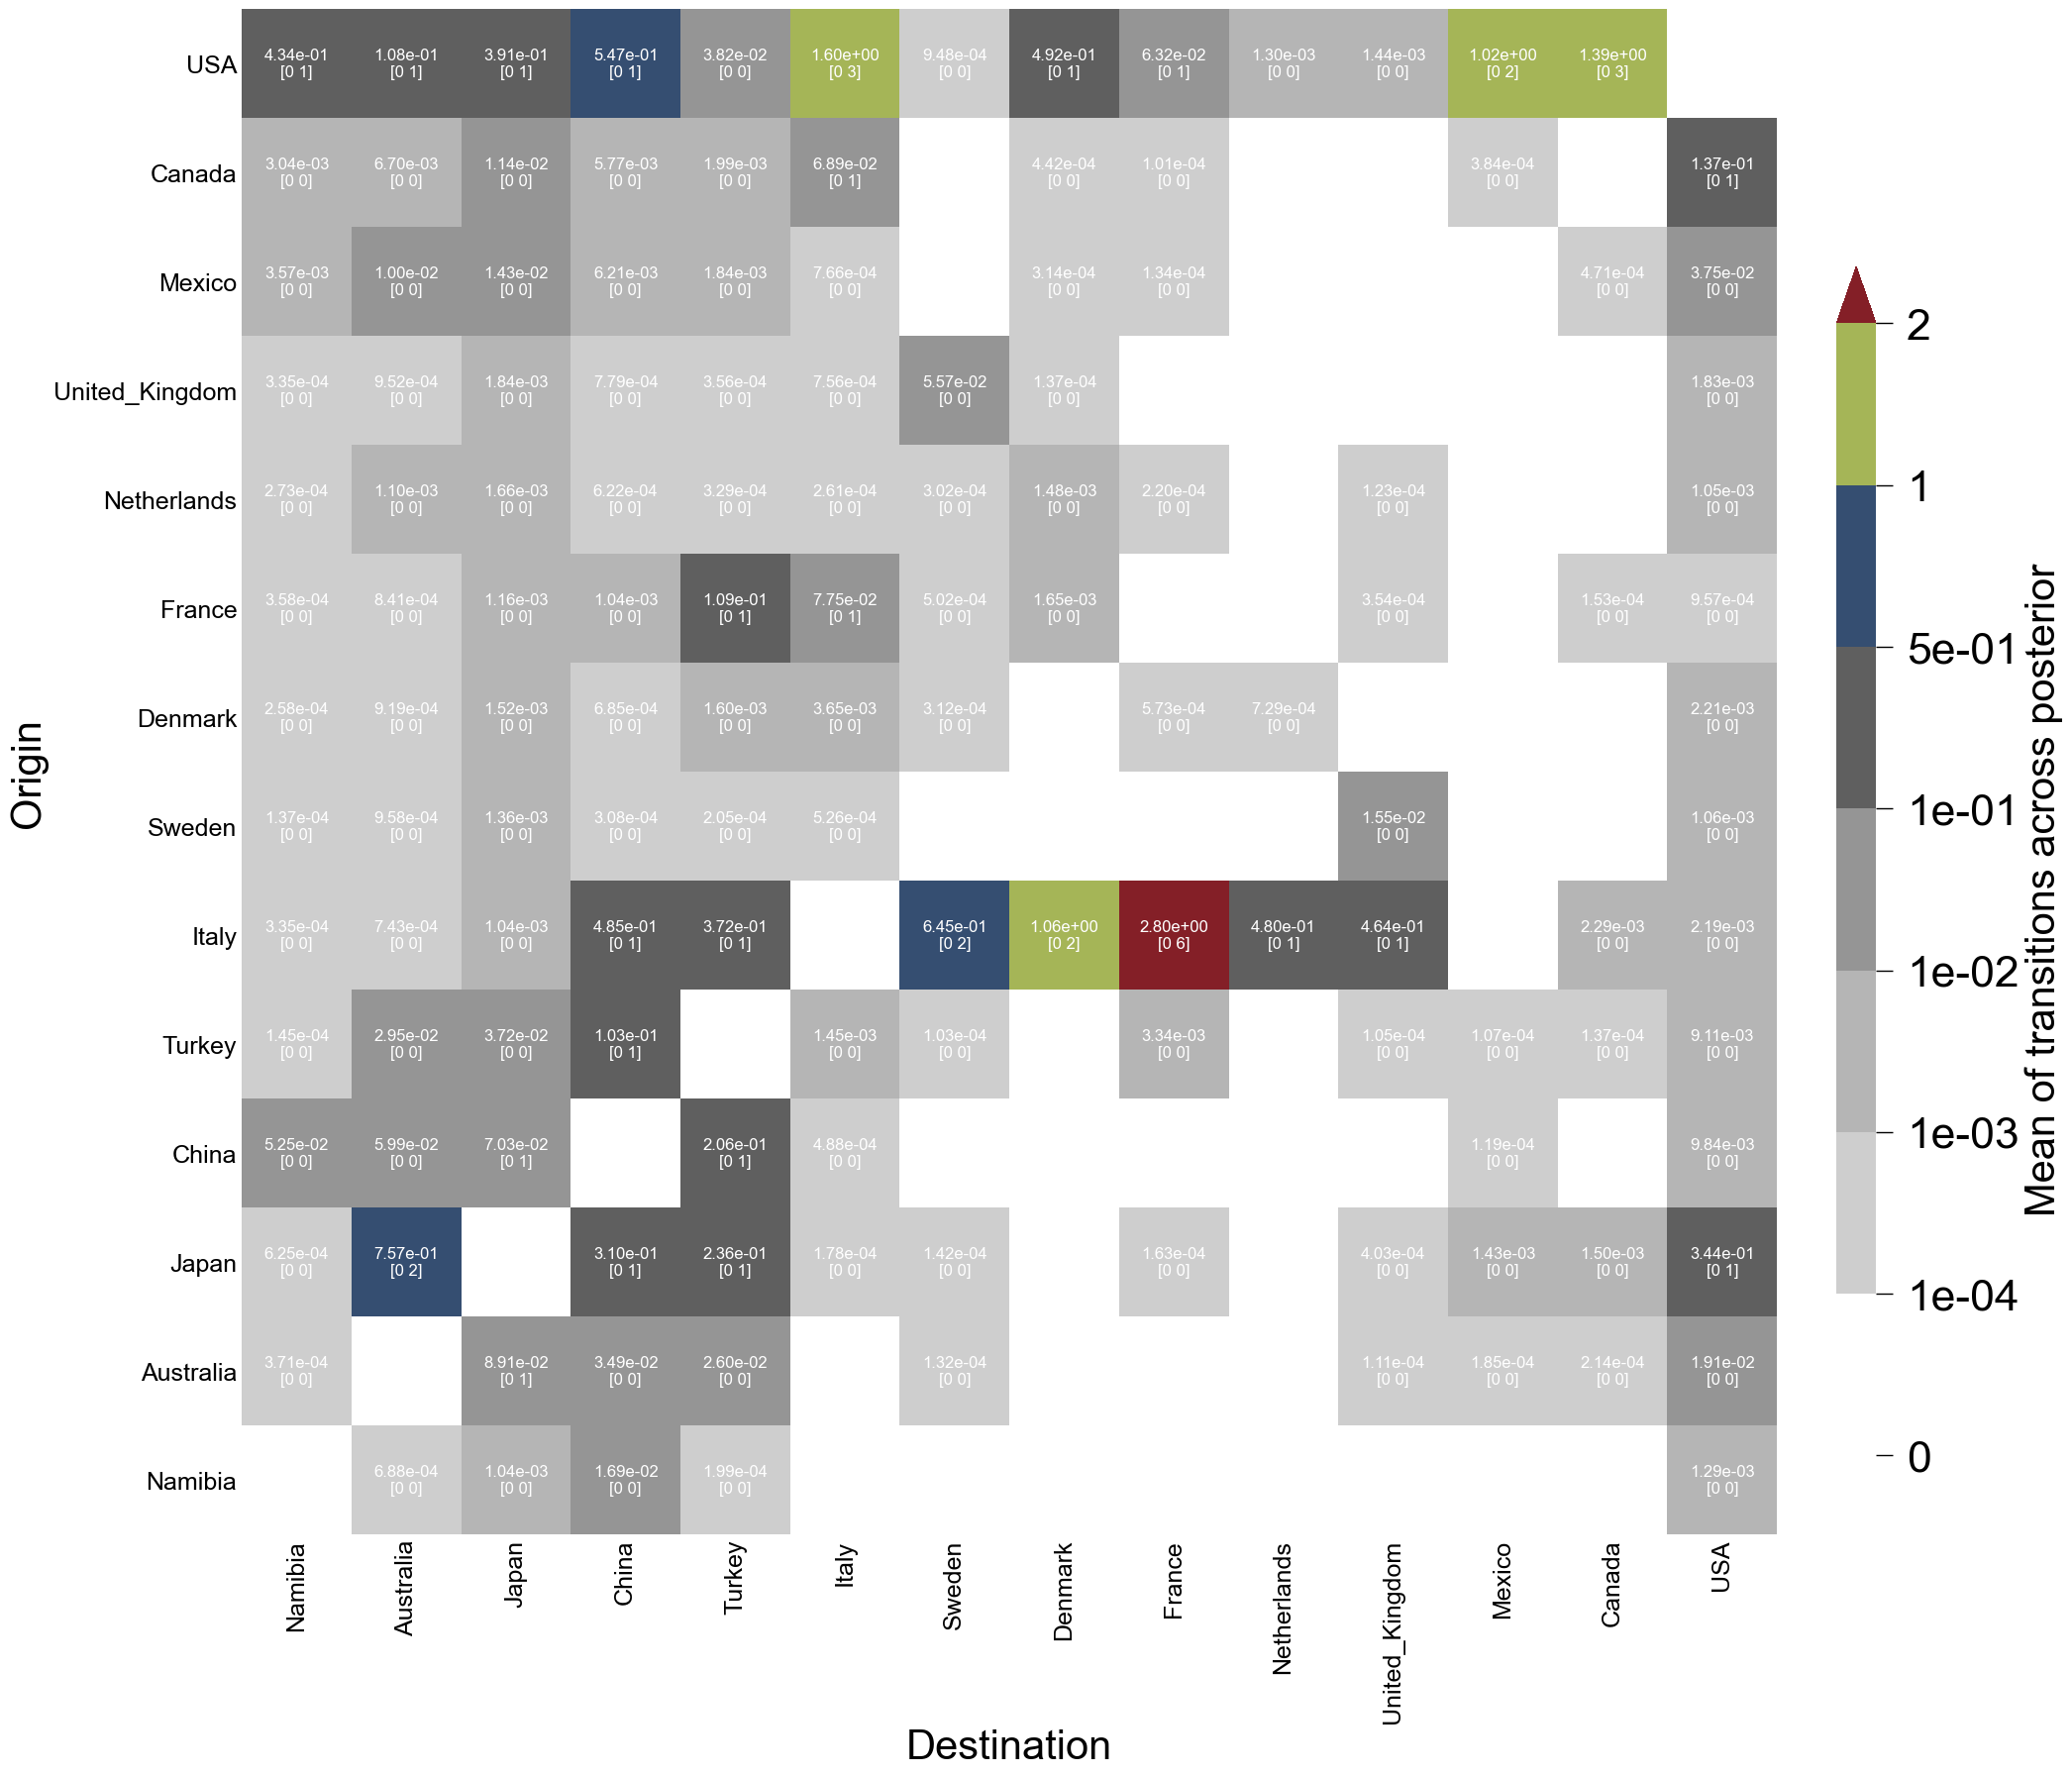

In [9]:
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.ticker import LogFormatterMathtext

# Set up the figure
fig, ax = plt.subplots(figsize=(20, 20), facecolor='w')

# Mask NaN values
masked_array = np.ma.masked_invalid(analysis.values)

clist=[(0,'w'), ## 0 cases is white
       (10.0**-4,mpl.cm.Greys(0.3)), #<1 greys
       (10.0**-3,mpl.cm.Greys(0.4)),
       (10.0**-2,mpl.cm.Greys(0.5)),
       (10.0**-1,mpl.cm.Greys(0.7)),
       (0.5, "#354E71"),
       (1, "#A5B557"),
       (2, "#841F27")]

# Define a custom colormap with discrete colors for the heatmap
boundaries,colours=zip(*clist)

cmap=mpl.colors.ListedColormap(colours) ## create colour map
# Explicitly set NaN values to light grey
cmap.set_bad('w', 1.0)

norm = mpl.colors.BoundaryNorm(boundaries, cmap.N,extend='max') ## discrete colour map

# Plot the heatmap using pcolormesh
heatmap = ax.pcolormesh(masked_array, cmap=cmap, norm=norm, edgecolors='none', linewidths=0)

# Set tick labels and rotation for clarity
ax.set_yticks(np.arange(0.5, len(ordered_locations) + 0.5))
ax.set_yticklabels(ordered_locations)
ax.set_xticks(np.arange(0.5, len(ordered_locations) + 0.5))
ax.set_xticklabels(ordered_locations, rotation=90)

# Set axis labels
ax.set_xlabel('Destination', size=30)
ax.set_ylabel('Origin', size=30)
ax.tick_params(size=0, labelsize=18)

# Hide spines for a cleaner look
for spine in ax.spines.values():
    spine.set_visible(False)

# Add text annotations to each square
for i in range(masked_array.shape[0]):
    for j in range(masked_array.shape[1]):
        # Only add text if the value is not NaN
        if not masked_array.mask[i, j]:
            # Use the ordered_locations list to get the correct country names
            origin_country = ordered_locations[i]
            destination_country = ordered_locations[j]

            # Get mean and HPD values
            mean_value = mean_migration[origin_country][destination_country]
            hpd_value = HPD_migration[origin_country][destination_country]

            # Prepare the text to display
            text_annotation = f"{mean_value:.2e}\n{hpd_value}"

            # Add text to the heatmap, including for zero values
            ax.text(j + 0.5, i + 0.5, text_annotation,
                    ha='center', va='center', color='white', fontsize=12)

# Add the colorbar on the side
axcb = fig.add_axes([0.93, 0.15, 0.02, 0.6], frame_on=False)
# Use LogFormatterMathtext for scientific notation in colorbar
cb = mpl.colorbar.ColorbarBase(axcb, cmap=cmap, norm=norm, orientation='vertical')
                               # ,format=LogFormatterMathtext())
# Custom ticks and labels for the colorbar
tick_locs = boundaries 
tick_labels = [f"{b:.0e}" if b < 1 and b != 0 else str(b) for b in tick_locs]  # Format in scientific notation
cb.set_ticks(tick_locs)
cb.set_ticklabels(tick_labels)

# Colorbar label
axcb.set_ylabel('Mean of transitions across posterior', size=30)
axcb.tick_params(axis='y', which='both', direction='out', size=12, width=1, pad=10)

# Set colorbar tick label size
plt.setp(axcb.get_yticklabels(), size=32)

plt.show()

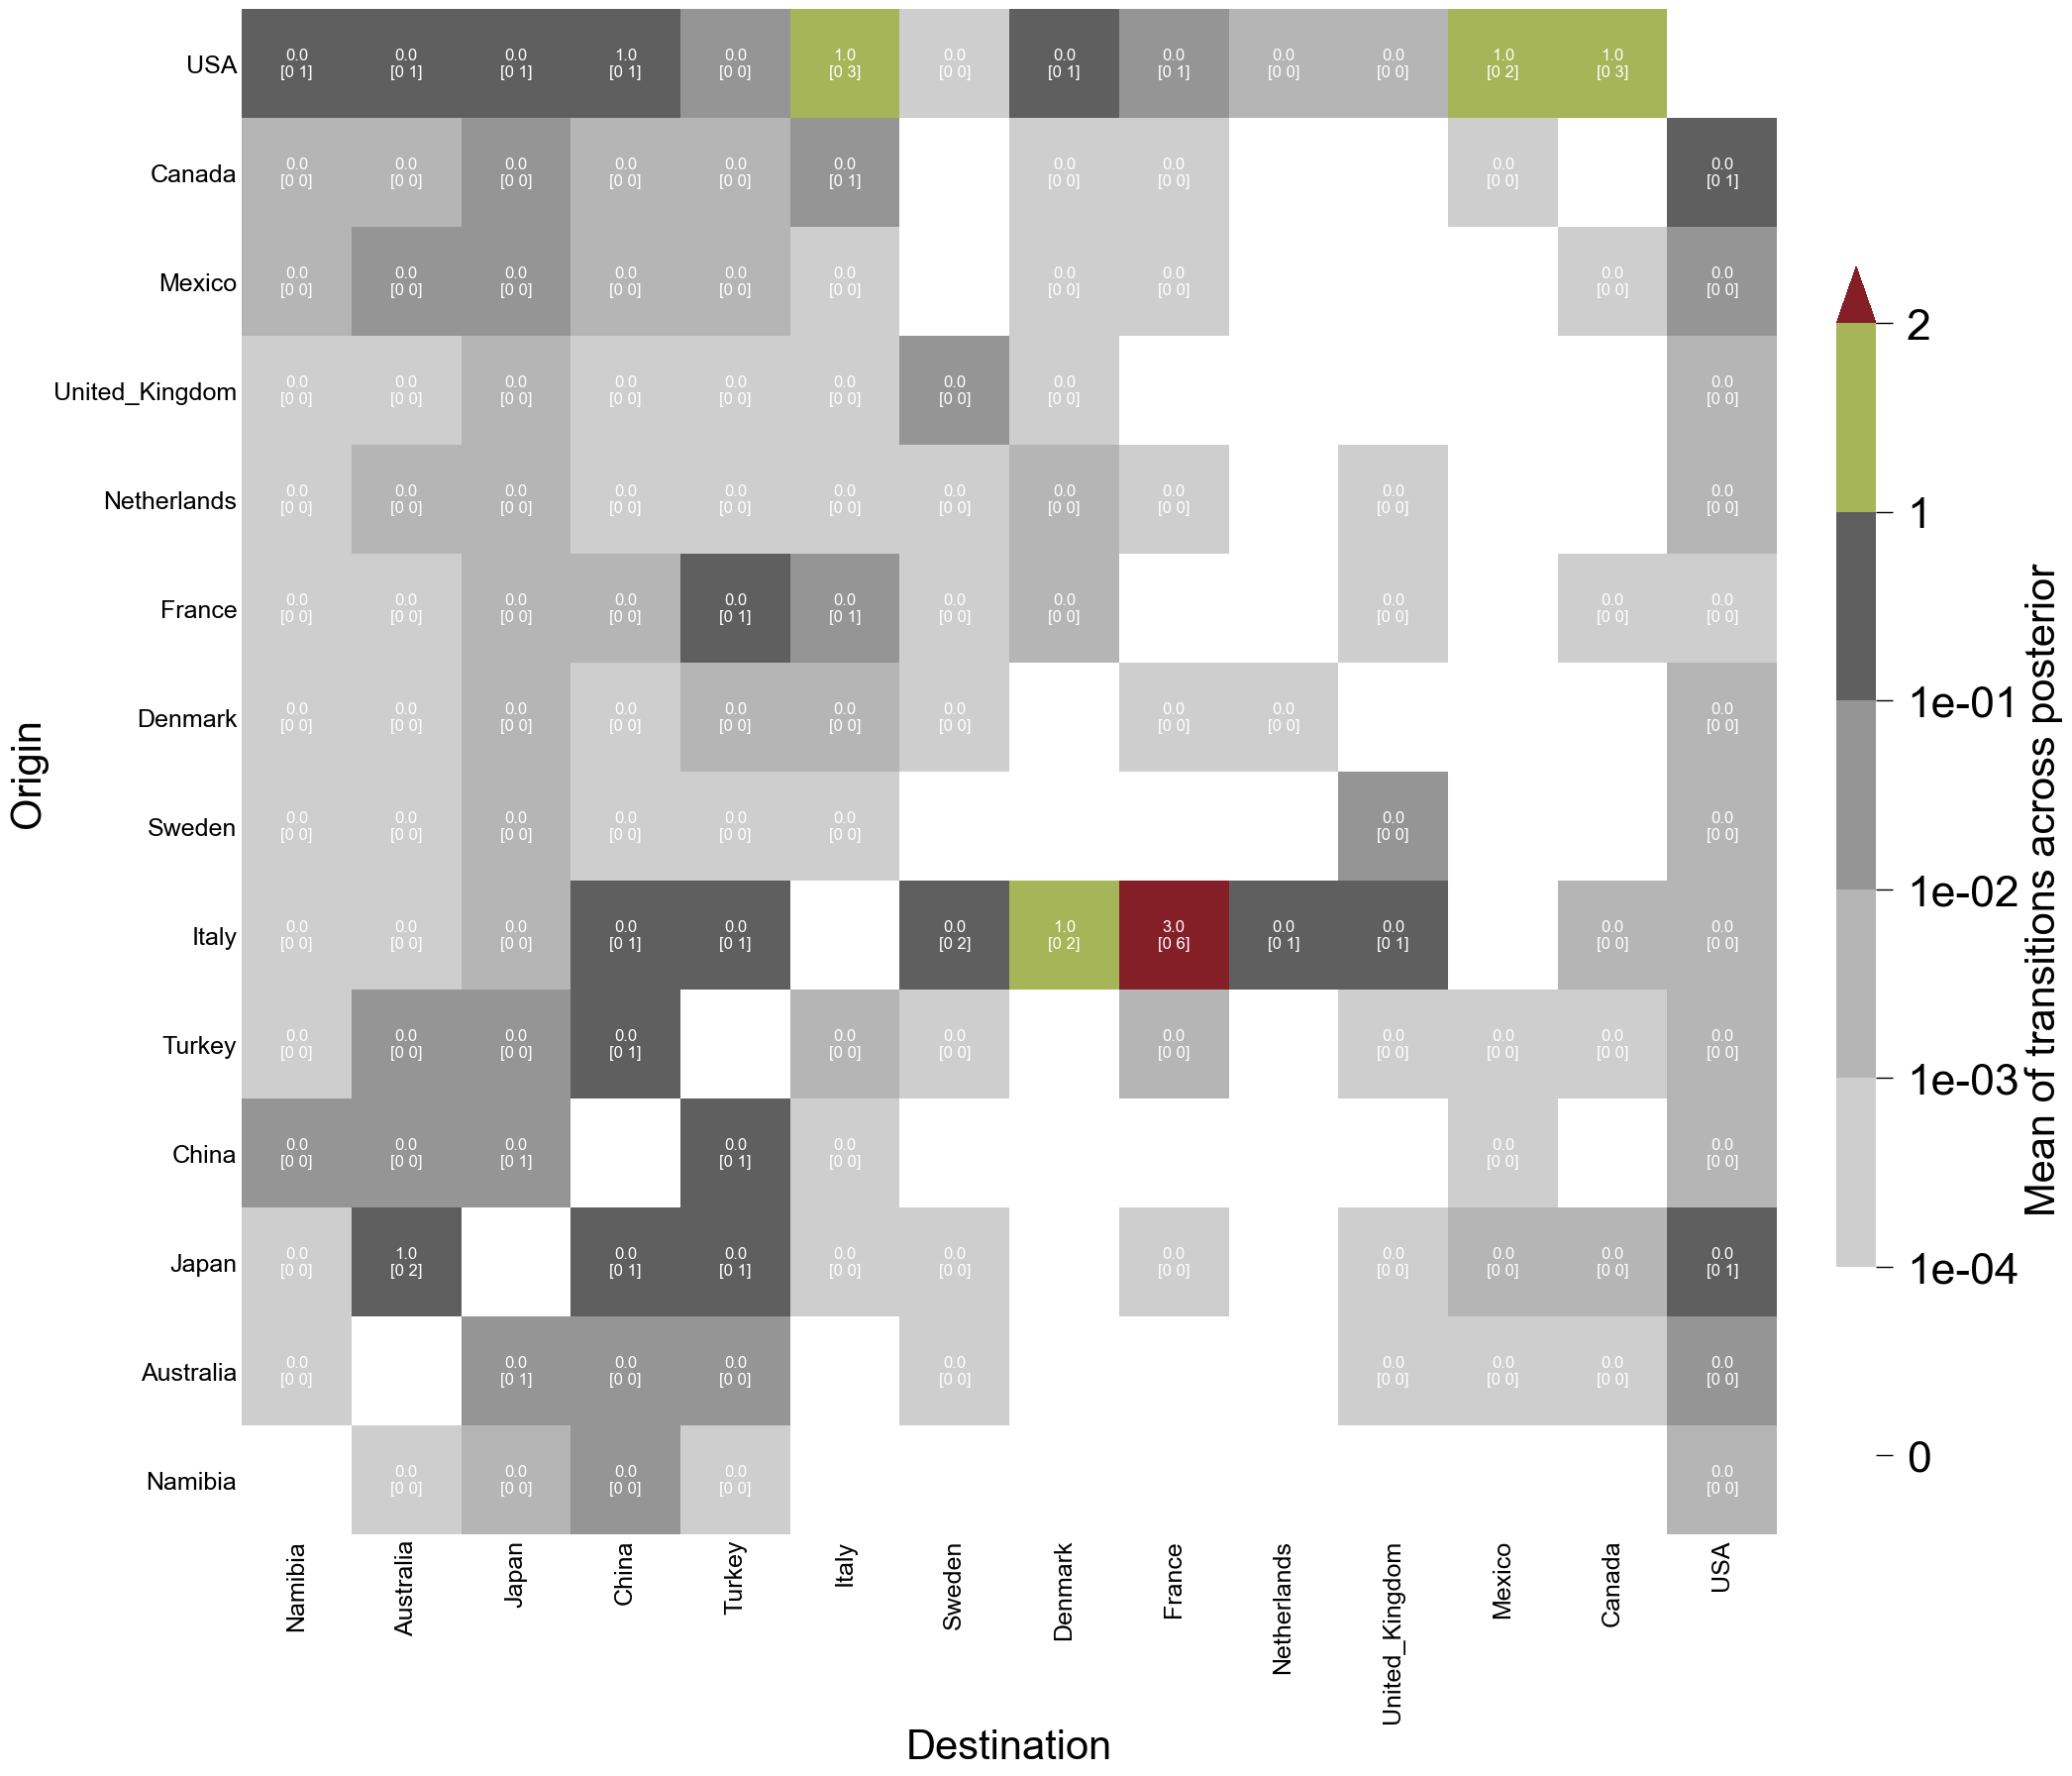

In [10]:
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.ticker import LogFormatterMathtext

# Set up the figure
fig, ax = plt.subplots(figsize=(20, 20), facecolor='w')

# Mask NaN values
masked_array = np.ma.masked_invalid(analysis.values)

clist=[(0,'w'), ## 0 cases is white
       (10.0**-4,mpl.cm.Greys(0.3)), #<1 greys
       (10.0**-3,mpl.cm.Greys(0.4)),
       (10.0**-2,mpl.cm.Greys(0.5)),
       (10.0**-1,mpl.cm.Greys(0.7)),
       (1, "#A5B557"),
       (2, "#841F27")]

# Define a custom colormap with discrete colors for the heatmap
boundaries,colours=zip(*clist)

cmap=mpl.colors.ListedColormap(colours) ## create colour map
# Explicitly set NaN values to light grey
cmap.set_bad('w', 1.0)

norm = mpl.colors.BoundaryNorm(boundaries, cmap.N,extend='max') ## discrete colour map

# Plot the heatmap using pcolormesh
heatmap = ax.pcolormesh(masked_array, cmap=cmap, norm=norm, edgecolors='none', linewidths=0)

# Set tick labels and rotation
ax.set_yticks(np.arange(0.5, len(ordered_locations) + 0.5))
ax.set_yticklabels(ordered_locations)
ax.set_xticks(np.arange(0.5, len(ordered_locations) + 0.5))
ax.set_xticklabels(ordered_locations, rotation=90)

# Set axis labels
ax.set_xlabel('Destination', size=30)
ax.set_ylabel('Origin', size=30)
ax.tick_params(size=0, labelsize=18)

# Hide spines for a cleaner look
for spine in ax.spines.values():
    spine.set_visible(False)

# Add text annotations to each square
for i in range(masked_array.shape[0]):
    for j in range(masked_array.shape[1]):
        # Only add text if the value is not NaN
        if not masked_array.mask[i, j]:
            # Use the ordered_locations list to get the correct country names
            origin_country = ordered_locations[i]
            destination_country = ordered_locations[j]

            # Get mean and HPD values
            median_value = median_migration[origin_country][destination_country]
            hpd_value = HPD_migration[origin_country][destination_country]

            # Prepare the text to display
            text_annotation = f"{median_value}\n{hpd_value}"

            # Add text to the heatmap, including for zero values
            ax.text(j + 0.5, i + 0.5, text_annotation,
                    ha='center', va='center', color='white', fontsize=12)

# Add the colorbar on the side
axcb = fig.add_axes([0.93, 0.15, 0.02, 0.6], frame_on=False)
# Use LogFormatterMathtext for scientific notation in colorbar
cb = mpl.colorbar.ColorbarBase(axcb, cmap=cmap, norm=norm, orientation='vertical')
                               # ,format=LogFormatterMathtext())
# Custom ticks and labels for the colorbar
tick_locs = boundaries 
tick_labels = [f"{b:.0e}" if b < 1 and b != 0 else str(b) for b in tick_locs]  # Format in scientific notation
cb.set_ticks(tick_locs)
cb.set_ticklabels(tick_labels)

# Colorbar label
axcb.set_ylabel('Mean of transitions across posterior', size=30)
axcb.tick_params(axis='y', which='both', direction='out', size=12, width=1, pad=10)

# Set colorbar tick label size
plt.setp(axcb.get_yticklabels(), size=32)

plt.show()
